# Forecast Exploration Notebook
This notebooks on predicting future performance of the world economy and financial markets based on financial time sereis and the world events time series (generated by the NLP workstream).

## DeepAR

In [4]:
# pip install "gluonts[torch]"

In [5]:
# Importing the necessary packages 
from gluonts.dataset.common import ListDataset
from gluonts.dataset.split import split

from gluonts.torch import DeepAREstimator

from gluonts.evaluation import Evaluator, backtest_metrics
from gluonts.evaluation import make_evaluation_predictions
from gluonts.model.evaluation import evaluate_model
from gluonts.evaluation.metrics import mape

import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
from datetime import datetime

/opt/conda/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Load Stock-Indices TTS from a CSV file into a DataFrame
file_name = "indices.csv"
file_path = f"../../data_engineering/financial_ts/{file_name}"
tts_df = pd.read_csv(file_path)
# Format DataFrame
tts_col_map = {i:f"rts_f_{i}" for i in tts_df.columns if i.isnumeric()}
tts_df = tts_df.rename(columns={'Unnamed: 0': 'Week'})
tts_df['Week'] = tts_df['Week'].apply(lambda x: datetime.fromisoformat(x))
tts_df = tts_df.set_index('Week')
# Rename Columns
tts_col_map = {i:f"tts_{i}" for i in tts_df.columns}
tts_df = tts_df.rename(columns=tts_col_map)
tts_df.head()

,tts_NASDAQ,tts_S&P,tts_IT_ETF,tts_United_States_Oil_Fund(USO),tts_Farming_ETF,tts_MSCI_World,tts_Emerging_markets,tts_DAX
Week,,,,,,,,
1971-02-08,100.839996,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1971-02-15,102.050003,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1971-02-22,99.680000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1971-03-01,101.779999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1971-03-08,104.230003,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Load Financial RTS from a CSV file into a DataFrame
file_name = "ww_gdp.csv"
file_path = f"../../data_engineering/financial_ts/{file_name}"
rts_f_df = pd.read_csv(file_path)
# Format DataFrame
# rts_f_col_map = {i:f"rts_f_{i}" for i in rts_f_df.columns if i.isnumeric()}
rts_f_df = rts_f_df.rename(columns={'Unnamed: 0': 'Week'})
rts_f_df['Week'] = rts_f_df['Week'].apply(lambda x: datetime.fromisoformat(x))
rts_f_df = rts_f_df.set_index('Week')
# Rename Columns
rts_f_col_map = {i:f"rts_f_{i}" for i in rts_f_df.columns}
rts_f_df = rts_f_df.rename(columns=rts_f_col_map)
rts_f_df.head()

,rts_f_Aruba,rts_f_Africa Eastern and Southern,rts_f_Afghanistan,rts_f_Africa Western and Central,rts_f_Angola,rts_f_Albania,rts_f_Andorra,rts_f_Arab World,rts_f_United Arab Emirates,rts_f_Argentina,...,rts_f_Virgin Islands (U.S.),rts_f_Vietnam,rts_f_Vanuatu,rts_f_World,rts_f_Samoa,rts_f_Kosovo,rts_f_Yemen,rts_f_South Africa,rts_f_Zambia,rts_f_Zimbabwe
Week,,,,,,,,,,,,,,,,,,,,,
1960-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Load Event RTS from a CSV file into a DataFrame
file_name = "ts_dgelt_events.csv"
file_path = f"../../data_engineering/timeseries_data/{file_name}"
rts_e_df = pd.read_csv(file_path)
# Format DataFrame
rts_e_col_map = {i:f"rts_e_{i}" for i in rts_e_df.columns if i.isnumeric()}
rts_e_df = rts_e_df.rename(
    columns=dict({'DATEADDED': 'Week'}, **rts_e_col_map)
)
rts_e_df['Week'] = rts_e_df['Week'].apply(lambda x: datetime.fromisoformat(x))
rts_e_df = rts_e_df.set_index('Week')
rts_e_df.index = rts_e_df.index.tz_localize(None)

rts_e_df.head()

,rts_e_10,rts_e_11,rts_e_12,rts_e_13,rts_e_14,rts_e_15,rts_e_16,rts_e_17,rts_e_18,rts_e_19,...,rts_e_1712,rts_e_1721,rts_e_1722,rts_e_1723,rts_e_1724,rts_e_1821,rts_e_1822,rts_e_1823,rts_e_1831,rts_e_1832
Week,,,,,,,,,,,,,,,,,,,,,
2015-02-23,4023.0,NaN,396.0,136.0,NaN,NaN,NaN,121.0,NaN,NaN,...,122.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-02,3376.0,NaN,778.0,720.0,140.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1652.0,NaN,130.0,NaN,NaN,NaN,NaN
2015-03-09,1729.0,NaN,2668.0,150.0,160.0,123.0,130.0,NaN,NaN,NaN,...,140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-16,2483.0,NaN,1190.0,160.0,130.0,NaN,NaN,820.0,NaN,NaN,...,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-23,4433.0,296.0,578.0,296.0,480.0,NaN,180.0,NaN,127.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,260.0,NaN


In [9]:
# Join TTS and RTS into a single DataFrame
ts_df = tts_df.join(rts_e_df)
# ts_df = ts_df.join(rts_f_df)
ts_df = ts_df.reset_index()
ts_df.head()

,Week,tts_NASDAQ,tts_S&P,tts_IT_ETF,tts_United_States_Oil_Fund(USO),tts_Farming_ETF,tts_MSCI_World,tts_Emerging_markets,tts_DAX,rts_e_10,...,rts_e_1712,rts_e_1721,rts_e_1722,rts_e_1723,rts_e_1724,rts_e_1821,rts_e_1822,rts_e_1823,rts_e_1831,rts_e_1832
0,1971-02-08,100.839996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1971-02-15,102.050003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1971-02-22,99.680000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1971-03-01,101.779999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1971-03-08,104.230003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In the following cell the pandas dataframe is converted into a [Dataset](https://ts.gluon.ai/stable/api/gluonts/gluonts.dataset.pandas.html) which gives the data additional explicid structure.

In [10]:
# Define the names of your columns
time_col = 'Week' 
target_col = 'tts_S&P'  
past_feat_cols = list(rts_e_col_map.values()) #+ list(rts_f_col_map.values()) 


In [11]:
# Create an empty list to store the time series dictionaries
time_series = []

# Iterate over the rows of the DataFrame
for _, row in ts_df.iterrows():
    start_time = row[time_col]
    target_value = row[target_col]
    past_feat_values = row[past_feat_cols].tolist()
    
    if pd.isna(target_value):  # Skip rows with missing target
        continue
        
    # Check for missing values in past_feat_values
    if any(np.isnan(past_feat_values)):
        # Handle missing values in past_feat_values
        # For example, you can replace missing values with 0 or impute them using an appropriate method
        past_feat_values = np.nan_to_num(past_feat_values, nan=0.0)

    # Create a time series dictionary and append it to the list
    time_series.append({
        "start": start_time, 
        "target": [target_value], 
        "feat_dynamic_real": [past_feat_values]
    })


In [12]:
# Target has to be a single value: https://ts.gluon.ai/stable/getting_started/models.html
dataset = ListDataset(time_series, freq='W')

In [13]:
# dataset[-100:-90]

In [14]:
# Split the data for training and testing
training_data, test_gen = split(dataset, offset=-56)
test_data = test_gen.generate_instances(prediction_length=56, windows=1)

In [15]:
# Train the model and make predictions
predictor = DeepAREstimator(
    prediction_length=56, 
    freq="W", 
    # batch_size=7,
    num_layers=2, # Number of RNN layers (default: 2).
    hidden_size=40, # Number of RNN cells for each layer (default: 40).
    trainer_kwargs={"max_epochs": 5}
).train(training_data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name  | Type        | Params | In sizes | Out sizes   
-------------------

Epoch 0: : 0it [00:00, ?it/s]

AssertionError: 

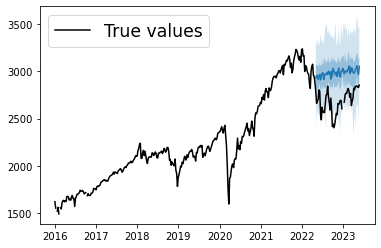

In [445]:
forecasts_it = list(model.predict(test_data.input))
# Plot predictions
plt.plot(tts_df[target_col]["2016":], color="black")
for forecast in forecasts:
  forecast.plot()
plt.legend(["True values"], loc="upper left", fontsize="xx-large")

In [446]:
forecasts = list(forecasts_it)
forecasts

[gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[3150.64  , 3217.6626, 3343.8928, ..., 2600.1228, 3153.066 ,
         3343.4377],
        [3170.0012, 3114.6855, 3430.961 , ..., 3844.409 , 3073.0994,
         3410.2373],
        [2927.763 , 3372.1553, 3148.5657, ..., 3221.9258, 3267.6353,
         3328.8474],
        ...,
        [3269.5823, 3213.4277, 3436.2212, ..., 3236.0383, 3279.5151,
         3309.3955],
        [2780.4895, 3168.8723, 2846.7092, ..., 3311.397 , 3287.0908,
         3407.7947],
        [3121.3164, 2962.8867, 2997.6106, ..., 3353.3887, 2745.0437,
         3744.5447]], dtype=float32), start_date=Period('2022-05-02/2022-05-08', 'W-SUN'))]

In [444]:
# Does not work !
# evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])  # Define the quantiles for evaluation
# agg_metrics, item_metrics = evaluator(tss, forecasts[0])